## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x.shape}')
print(f'Validation Features Shape: {val_x.shape}')
print(f'Test Features Shape: {test_x.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


### Get Label Data

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [14]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [17]:
from keras.models import Sequential
from keras.layers import Input, Dense, GRU

### Function to Plot Losses

In [18]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [19]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [20]:
# create model
model_1 = Sequential()
model_1.add(Input(shape=(max_words, embedding_size)))
model_1.add(GRU(4))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

2025-03-12 23:50:18.237869: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
history_1 = model_1.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.4508 - loss: 1.1848 - val_acc: 0.6540 - val_loss: 0.8396
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.7071 - loss: 0.7446 - val_acc: 0.8600 - val_loss: 0.4460
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.8985 - loss: 0.3662 - val_acc: 0.9210 - val_loss: 0.3089
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9258 - loss: 0.2675 - val_acc: 0.9250 - val_loss: 0.2979
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9337 - loss: 0.2505 - val_acc: 0.9240 - val_loss: 0.2847
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9241 - loss: 0.2551 - val_acc: 0.9130 - val_loss: 0.3015
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9380 - loss: 0.2210 - val_acc: 0.9210 - val_loss: 0.2741
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9402 - loss: 0.2129 - val_acc: 0.9240 - val_loss: 0.2938
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step 

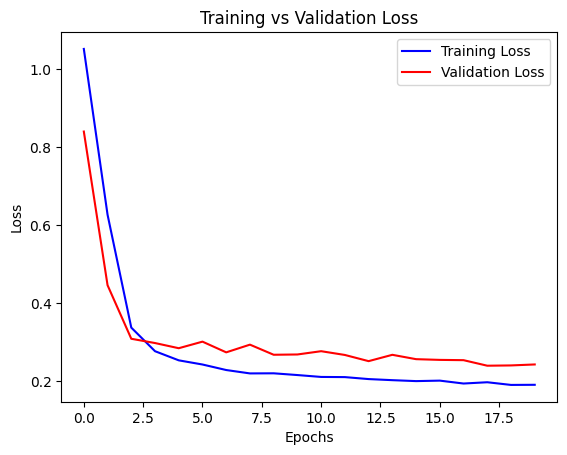

In [22]:
plot_losses(history_1)

### Conclusion: Steady Decrease of Validation loss for 20 epochs

## Model 2

### Increase epochs

In [23]:
# create model
model_2 = Sequential()
model_2.add(Input(shape=(max_words, embedding_size)))
model_2.add(GRU(4))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [24]:
history_2 = model_2.fit(train_x, train_y, epochs=30, batch_size=8, validation_data=(val_x, val_y))

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.5009 - loss: 1.1588 - val_acc: 0.7820 - val_loss: 0.7013
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.7882 - loss: 0.6172 - val_acc: 0.7970 - val_loss: 0.5342
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.8339 - loss: 0.4588 - val_acc: 0.8690 - val_loss: 0.4068
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9014 - loss: 0.3614 - val_acc: 0.9030 - val_loss: 0.3324
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9252 - loss: 0.2786 - val_acc: 0.9150 - val_loss: 0.2752
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.9294 - loss: 0.2516 - val_acc: 0.9160 - val_loss: 0.2890
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9397 - loss: 0.2263 - val_acc: 0.9300 - val_loss: 0.2599
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9404 - loss: 0.2178 - val_acc: 0.9320 - val_loss: 0.2606
Epoch 9/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step -

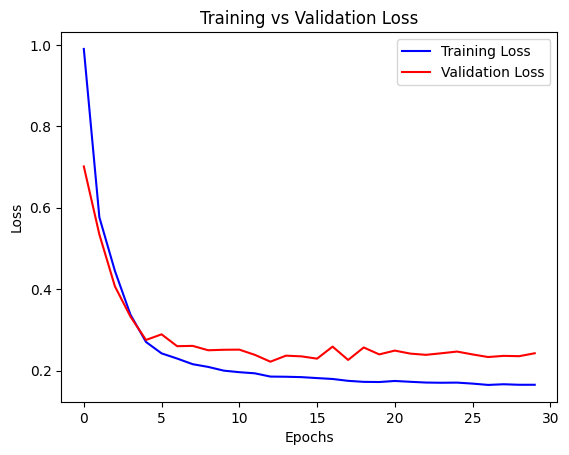

In [25]:
plot_losses(history_2)

### Conclusion: Training behaviour shows that the model reaches lowest validation loss in 13 epochs, after which it fluctuates around slightly higher values

## Model 3

### Increase Nodes

In [28]:
# create model
model_3 = Sequential()
model_3.add(Input(shape=(max_words, embedding_size)))
model_3.add(GRU(8))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [29]:
history_3 = model_3.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks = early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5688 - loss: 1.0259 - val_acc: 0.8260 - val_loss: 0.5100
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.8660 - loss: 0.4178 - val_acc: 0.9220 - val_loss: 0.2934
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9251 - loss: 0.2621 - val_acc: 0.9230 - val_loss: 0.2845
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.9316 - loss: 0.2324 - val_acc: 0.9300 - val_loss: 0.2645
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - acc: 0.9410 - loss: 0.1956 - val_acc: 0.9270 - val_loss: 0.2597
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.9380 - loss: 0.2078 - val_acc: 0.9110 - val_loss: 0.3176
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9436 - loss: 0.1861 - val_acc: 0.9330 - val_loss: 0.2416
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9491 - loss: 0.2003 - val_acc: 0.9350 - val_loss: 0.2527
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/s

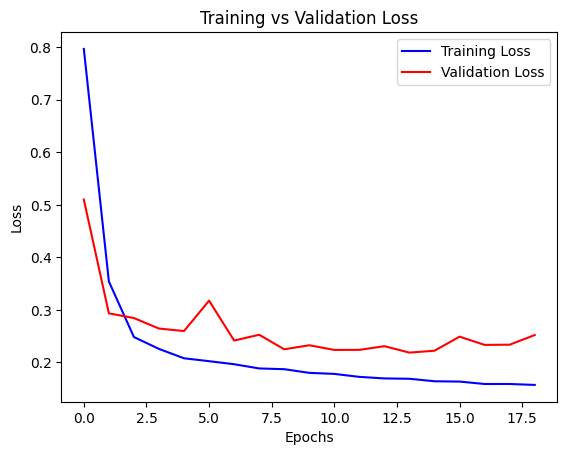

In [30]:
plot_losses(history_3)

### Conclusion: Increasing Nodes from 4 to 8 brings a slightly better performance (Validation loss  decreases from 0.2218 to 0.2187) 

## Model 4

### Increase Nodes to 16

In [31]:
# create model
model_4 = Sequential()
model_4.add(Input(shape=(max_words, embedding_size)))
model_4.add(GRU(16))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [32]:
history_4 = model_4.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5878 - loss: 0.9566 - val_acc: 0.8870 - val_loss: 0.3579
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9226 - loss: 0.2697 - val_acc: 0.9250 - val_loss: 0.2786
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9331 - loss: 0.2351 - val_acc: 0.9290 - val_loss: 0.2436
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9446 - loss: 0.1980 - val_acc: 0.9320 - val_loss: 0.2294
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9416 - loss: 0.1973 - val_acc: 0.9330 - val_loss: 0.2292
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9447 - loss: 0.1879 - val_acc: 0.9320 - val_loss: 0.2354
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.9481 - loss: 0.1779 - val_acc: 0.9330 - val_loss: 0.2443
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.9538 - loss: 0.1669 - val_acc: 0.9140 - val_loss: 0.2874
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/

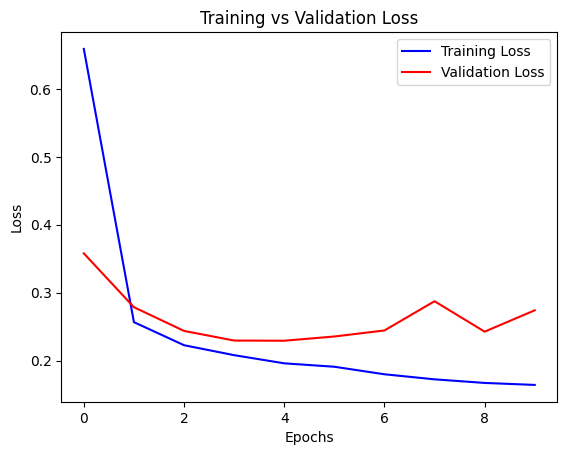

In [33]:
plot_losses(history_4)

### Conclusion: Model converges quicker, but performance is poorer compared to simpler model with 8 nodes

## Model 5

### Add layer

In [34]:
# create model
model_5 = Sequential()
model_5.add(Input(shape=(max_words, embedding_size)))
model_5.add(GRU(8, return_sequences=True))
model_5.add(GRU(4))
model_5.add(Dense(4, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [35]:
history_5 = model_5.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - acc: 0.5732 - loss: 1.0469 - val_acc: 0.8470 - val_loss: 0.4660
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - acc: 0.8887 - loss: 0.3873 - val_acc: 0.9120 - val_loss: 0.3122
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.9189 - loss: 0.2714 - val_acc: 0.9220 - val_loss: 0.2779
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9367 - loss: 0.2184 - val_acc: 0.9190 - val_loss: 0.2900
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.9389 - loss: 0.2231 - val_acc: 0.9220 - val_loss: 0.2682
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - acc: 0.9364 - loss: 0.2042 - val_acc: 0.9350 - val_loss: 0.2421
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9385 - loss: 0.2128 - val_acc: 0.9290 - val_loss: 0.2631
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.9423 - loss: 0.1948 - val_acc: 0.9330 - val_loss: 0.2417
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 

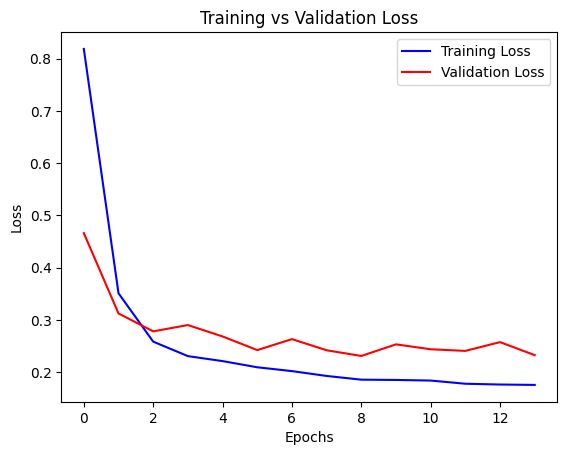

In [36]:
plot_losses(history_5)

### Conclusion: Performance decreases after adding layer

## Model 6

### Add Dropout

In [37]:
from keras.layers import Dropout

In [43]:
# create model
model_6 = Sequential()
model_6.add(Input(shape=(max_words, embedding_size)))
model_6.add(GRU(8))

# drop 10% of neurons
model_6.add(Dropout(0.1))

model_6.add(Dense(4, activation='sigmoid'))
model_6.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [44]:
history_6 = model_6.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5259 - loss: 1.1021 - val_acc: 0.8480 - val_loss: 0.4942
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8925 - loss: 0.3989 - val_acc: 0.9070 - val_loss: 0.3218
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9151 - loss: 0.3022 - val_acc: 0.9100 - val_loss: 0.3128
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9289 - loss: 0.2671 - val_acc: 0.9310 - val_loss: 0.2823
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9332 - loss: 0.2517 - val_acc: 0.9300 - val_loss: 0.2771
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9365 - loss: 0.2321 - val_acc: 0.9320 - val_loss: 0.2662
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - acc: 0.9420 - loss: 0.2199 - val_acc: 0.9300 - val_loss: 0.2733
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9452 - loss: 0.2261 - val_acc: 0.9330 - val_loss: 0.2316
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/

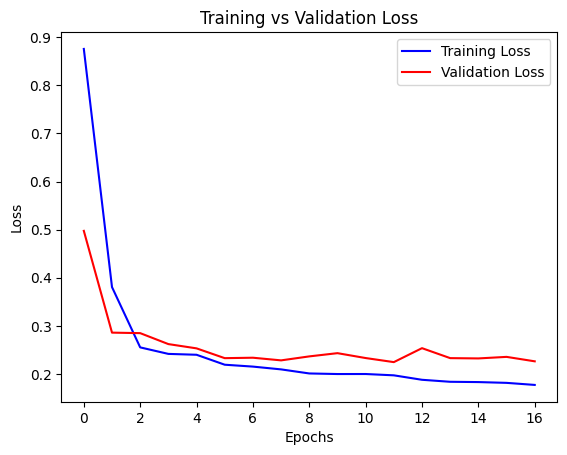

In [42]:
plot_losses(history_6)

### Conclusion: Validation loss increases slightly, while validation accuracy decreases slightly. There is no notieable impact on training accuracy either. Adding dropout, if anything, reduces performance slightly

## Model 7

### Add Regularization

In [45]:
from keras.regularizers import l2

In [49]:
# create model
model_7 = Sequential()
model_7.add(Input(shape=(max_words, embedding_size)))
model_7.add(GRU(8, kernel_regularizer=l2(0.001)))
model_7.add(Dense(4, activation='sigmoid'))
model_7.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [50]:
history_7 = model_7.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5113 - loss: 1.1564 - val_acc: 0.8250 - val_loss: 0.5278
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - acc: 0.8686 - loss: 0.4366 - val_acc: 0.8970 - val_loss: 0.3472
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9208 - loss: 0.3006 - val_acc: 0.9290 - val_loss: 0.2680
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9374 - loss: 0.2481 - val_acc: 0.9250 - val_loss: 0.2672
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9386 - loss: 0.2392 - val_acc: 0.9350 - val_loss: 0.2743
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9423 - loss: 0.2140 - val_acc: 0.9330 - val_loss: 0.2507
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9443 - loss: 0.2257 - val_acc: 0.9390 - val_loss: 0.2482
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9426 - loss: 0.2123 - val_acc: 0.9380 - val_loss: 0.2416
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/s

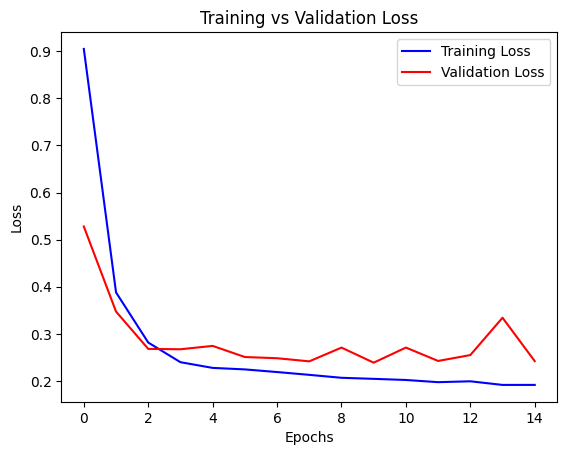

In [51]:
plot_losses(history_7)

### Conclusion: Though validation loss has increased from 0.2187 to 0.2388, accuracy has also increased from 0.938 to 0.941. Since regularisation keeps performance realtively stable, we choose to include it in the model to improve genralisation, since there is a small gap between training and validation losses

# Get Metrics on Test Set

In [52]:
from sklearn.metrics import classification_report, accuracy_score

In [53]:
y_pred = model_7.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0     0.9558    0.9520    0.9539       250
           1     0.9317    0.9280    0.9299       250
           2     0.9560    0.9560    0.9560       250
           3     0.9603    0.9680    0.9641       250

    accuracy                         0.9510      1000
   macro avg     0.9510    0.9510    0.9510      1000
weighted avg     0.9510    0.9510    0.9510      1000

Accuracy: 0.9510
